In [198]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import psycopg2
from psycopg2 import sql
import warnings
warnings.filterwarnings('ignore')

DB_HOST = 'localhost'
DB_NAME = 'tw'
DB_USER = 'mini'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn

conn = get_db_connection()
cursor = conn.cursor()
cursor.execute(sql.SQL("select code, da, cl from price where da > '2022-01-01' and da <= '2022-12-31' order by da asc;"))

res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['code', 'da', 'cl']
pivoted = df.pivot(index='da', values='cl', columns='code')

pivoted = pivoted.loc[:, ~pivoted.columns.str.startswith('0')]
pivoted = pd.read_parquet("stock_data_us_sp500.parquet").loc['2022-01-01':'2022-12-31']

pivoted_drop_latest = pivoted.iloc[:-7, :]
pivoted_dropna = pivoted_drop_latest.dropna(how='any', axis=1)
pct = pivoted_dropna.pct_change().fillna(0)
pct_cumprod = (1 + pct).cumprod() - 1

corrcoef = pd.DataFrame(np.corrcoef(pct_cumprod.T))
corrcoef.columns = pct_cumprod.columns
corrcoef.index = pct_cumprod.columns

  0%|          | 0/12 [00:00<?, ?it/s]

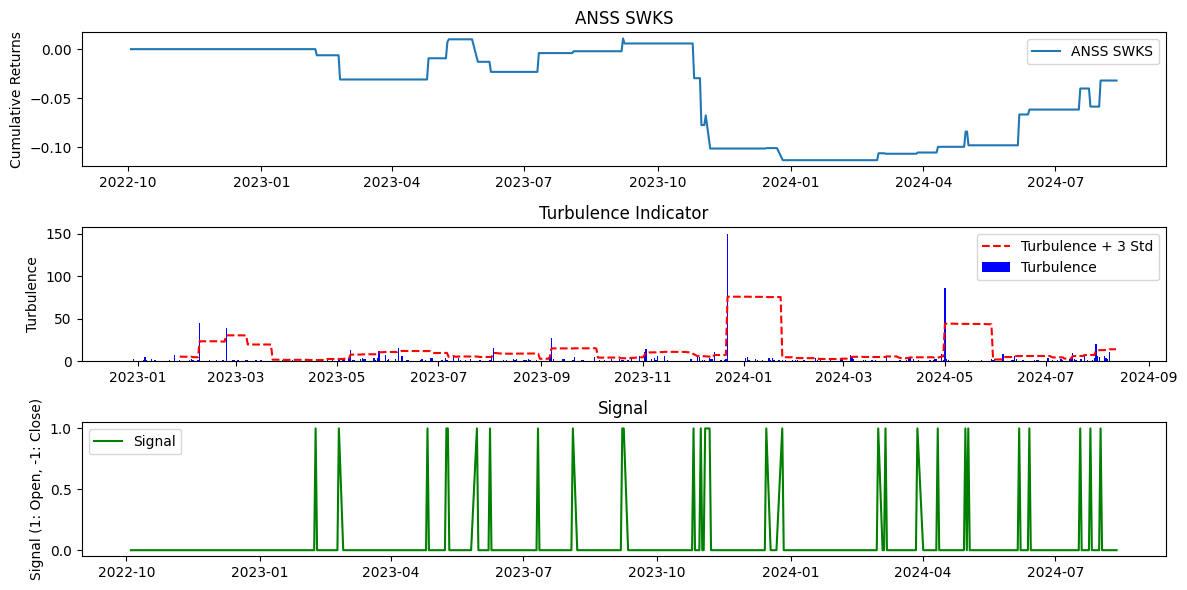

  8%|▊         | 1/12 [00:00<00:06,  1.68it/s]

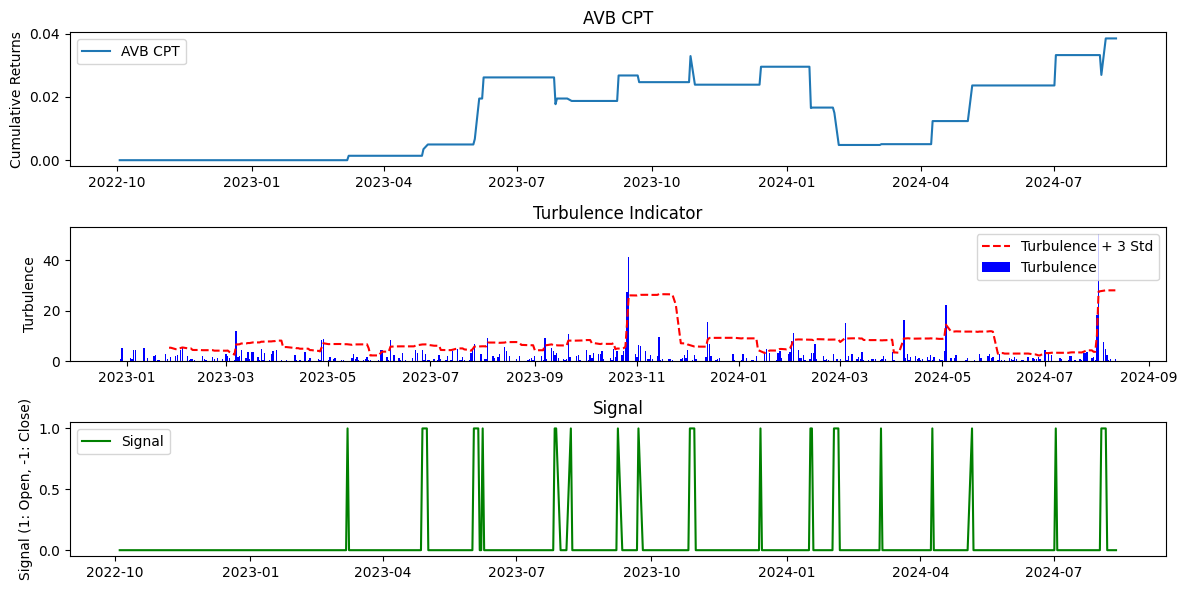

 17%|█▋        | 2/12 [00:01<00:05,  1.71it/s]

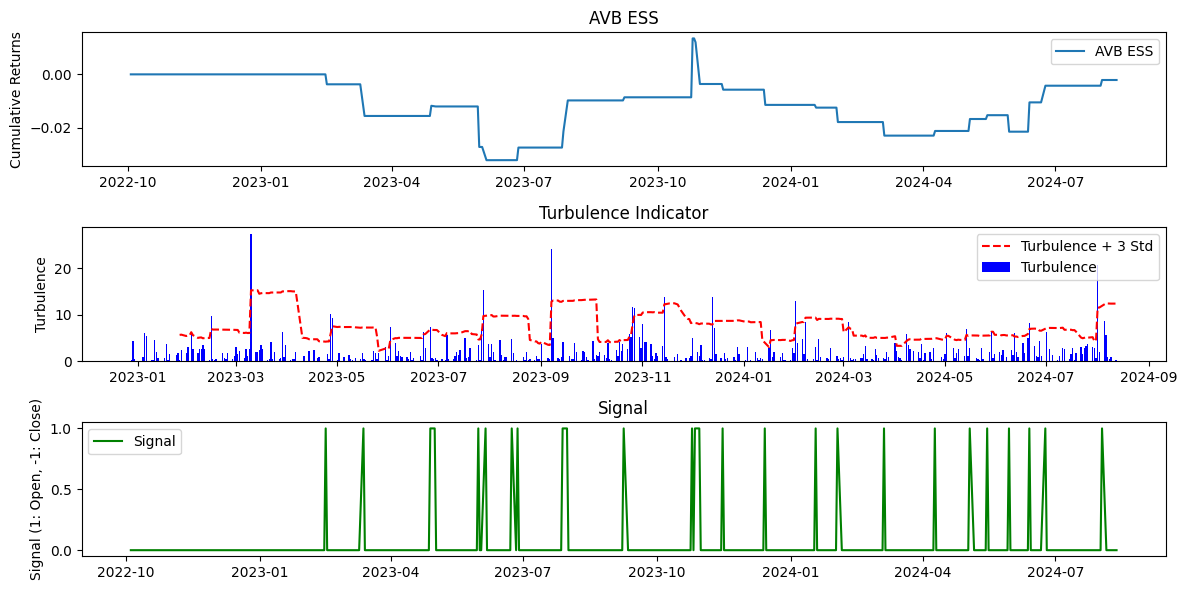

 25%|██▌       | 3/12 [00:01<00:05,  1.75it/s]

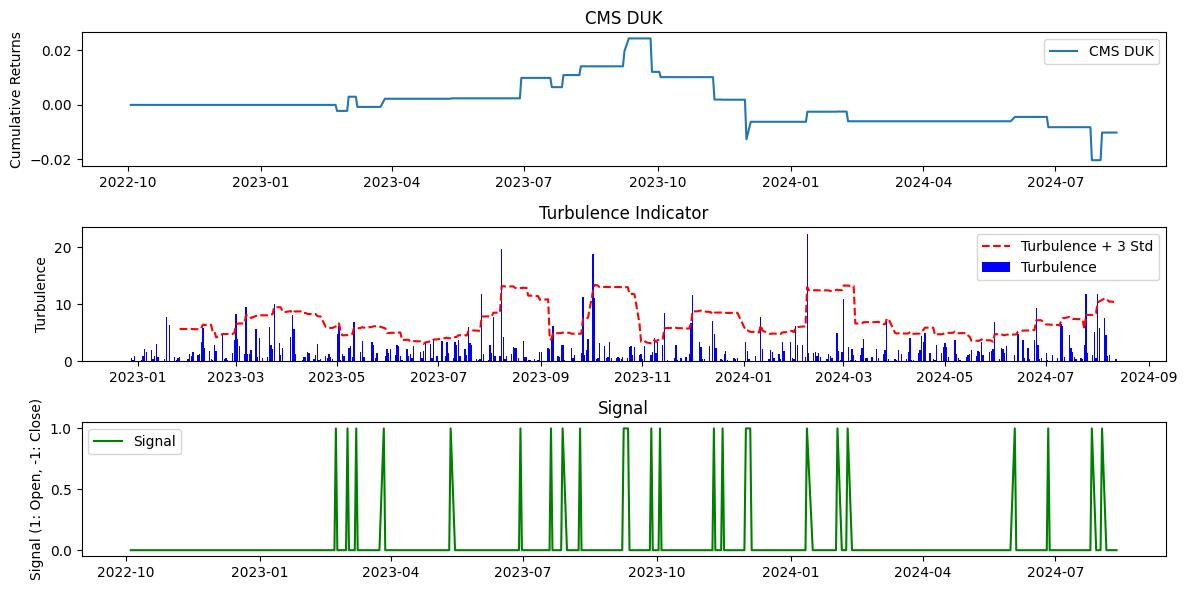

 33%|███▎      | 4/12 [00:03<00:07,  1.12it/s]

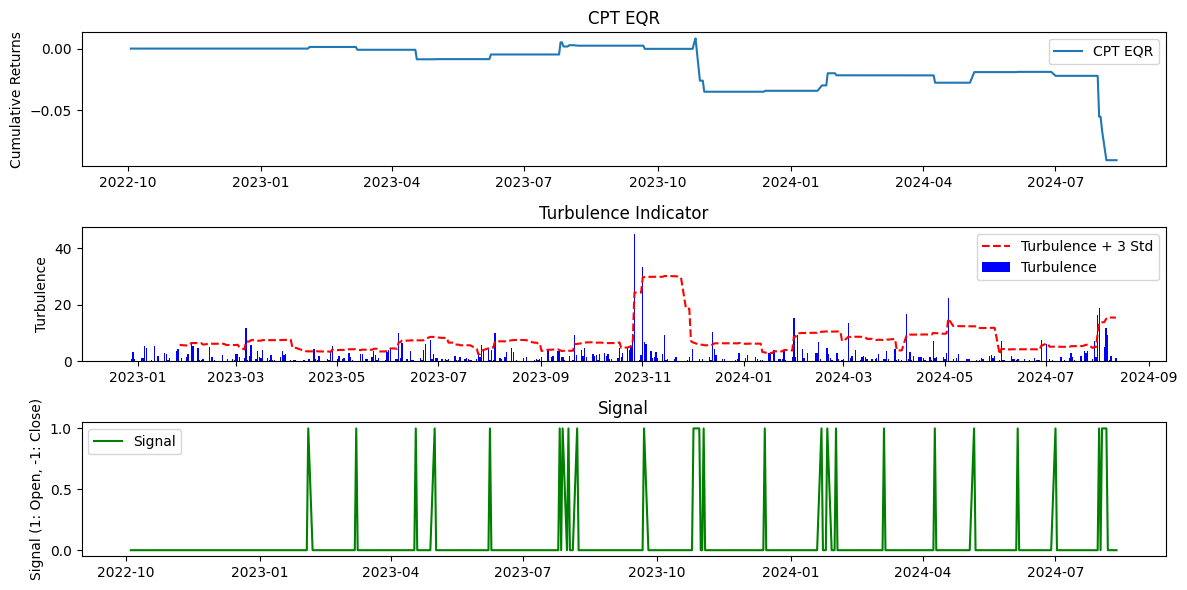

 42%|████▏     | 5/12 [00:03<00:05,  1.31it/s]

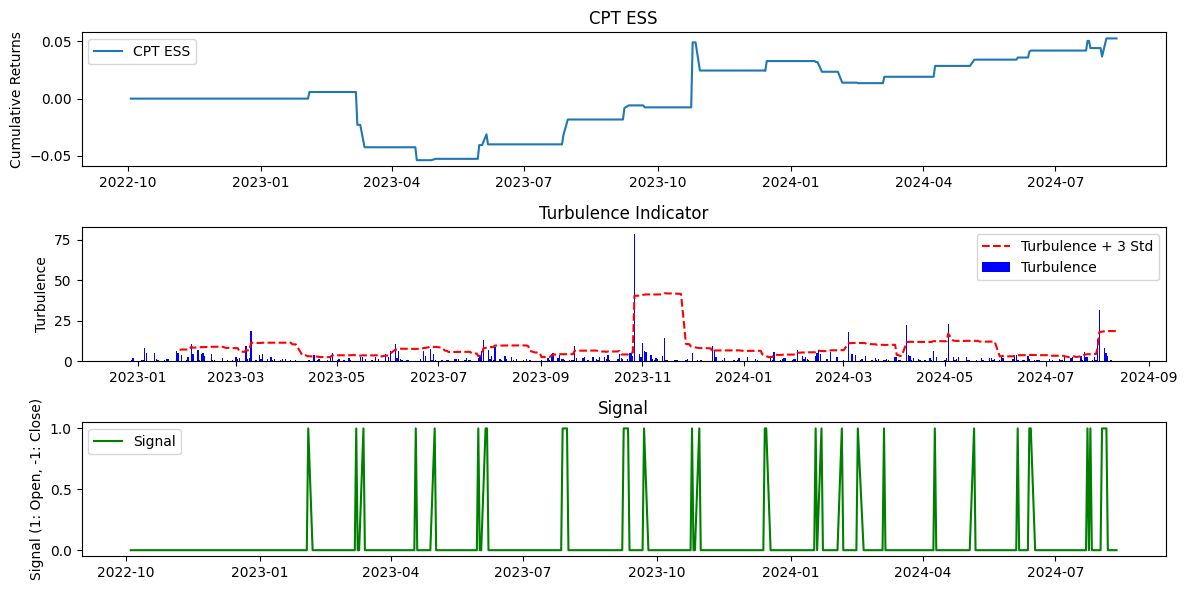

 50%|█████     | 6/12 [00:04<00:04,  1.46it/s]

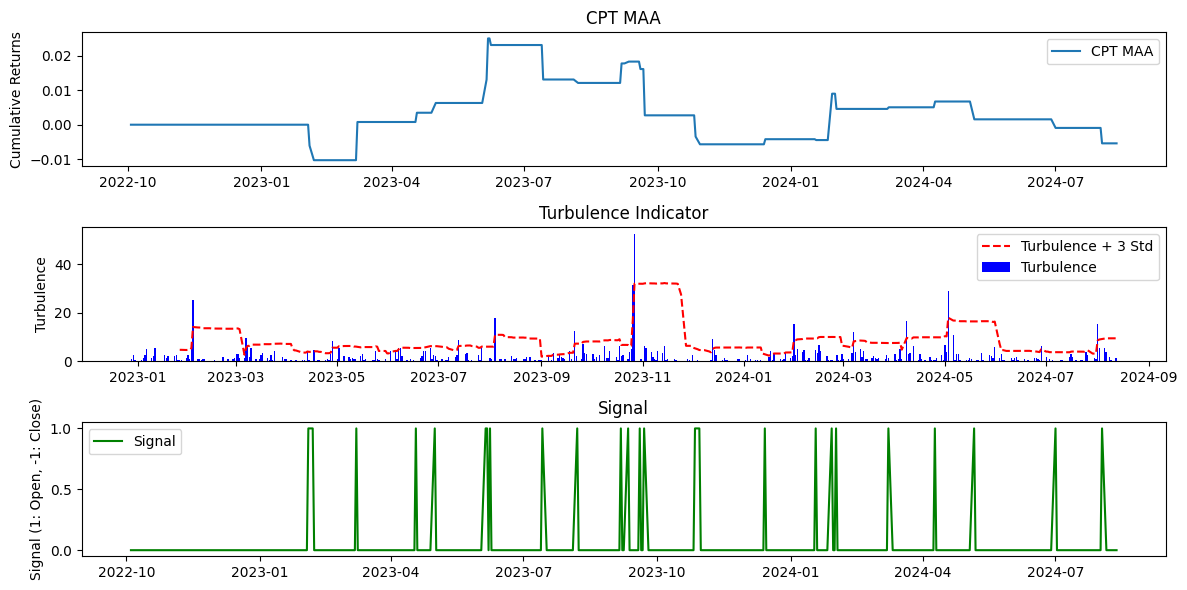

 58%|█████▊    | 7/12 [00:04<00:03,  1.57it/s]

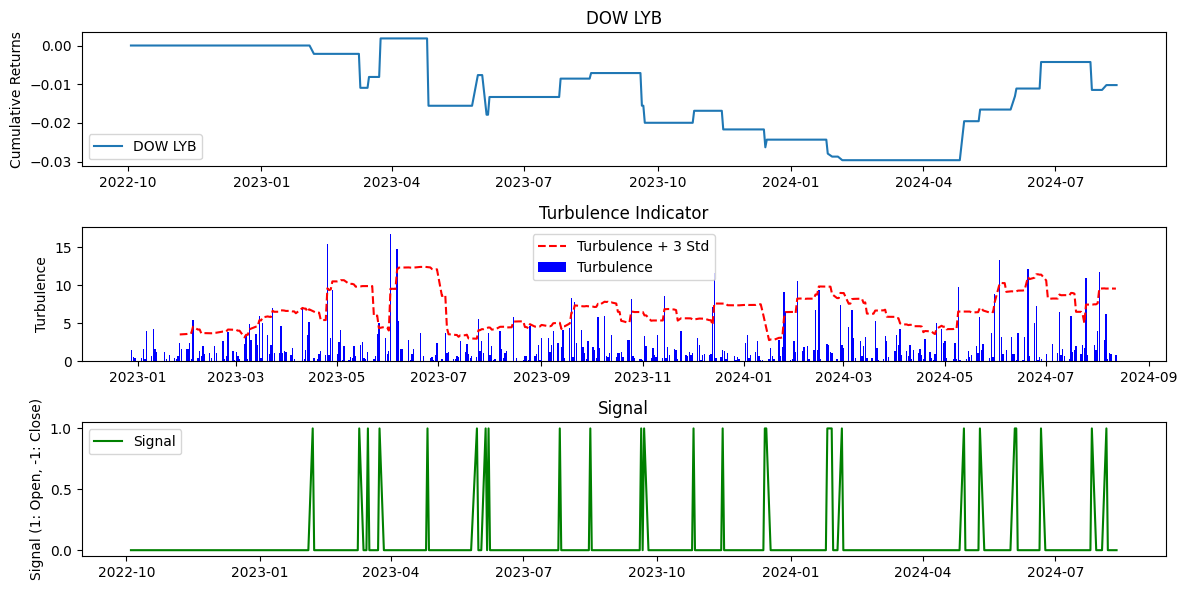

 67%|██████▋   | 8/12 [00:05<00:02,  1.66it/s]

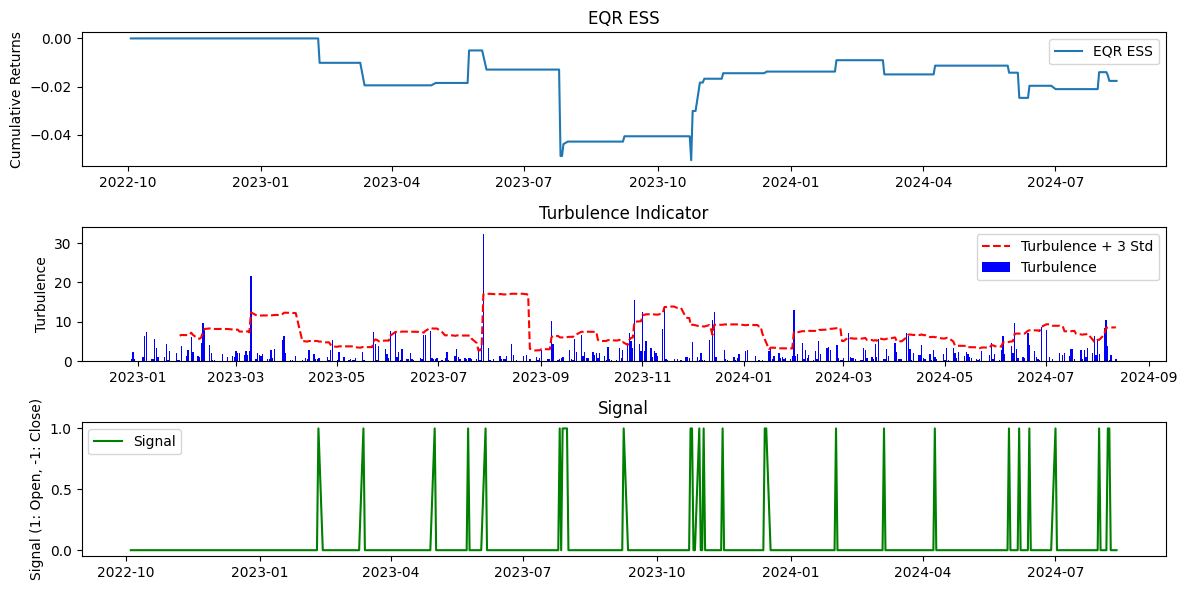

 75%|███████▌  | 9/12 [00:06<00:01,  1.53it/s]

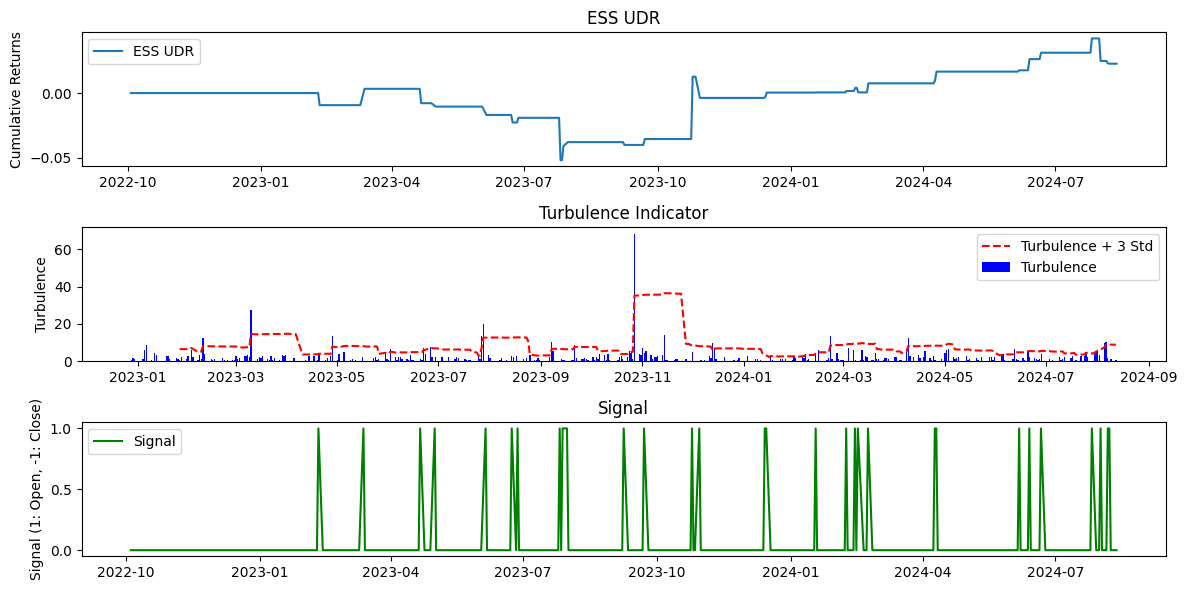

 83%|████████▎ | 10/12 [00:06<00:01,  1.62it/s]

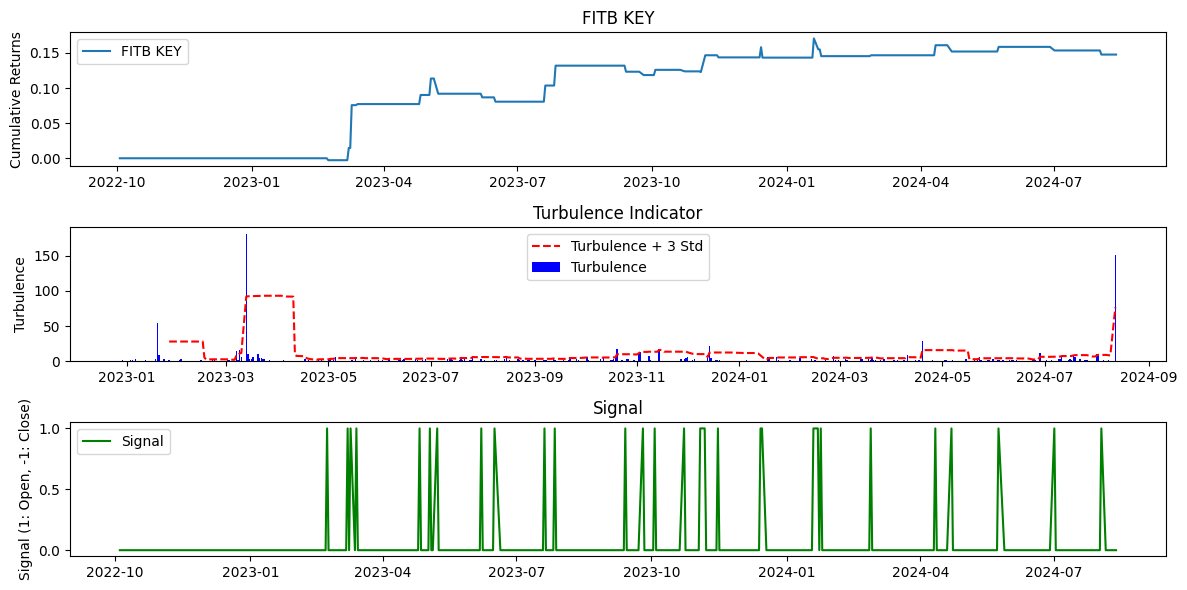

 92%|█████████▏| 11/12 [00:07<00:00,  1.68it/s]

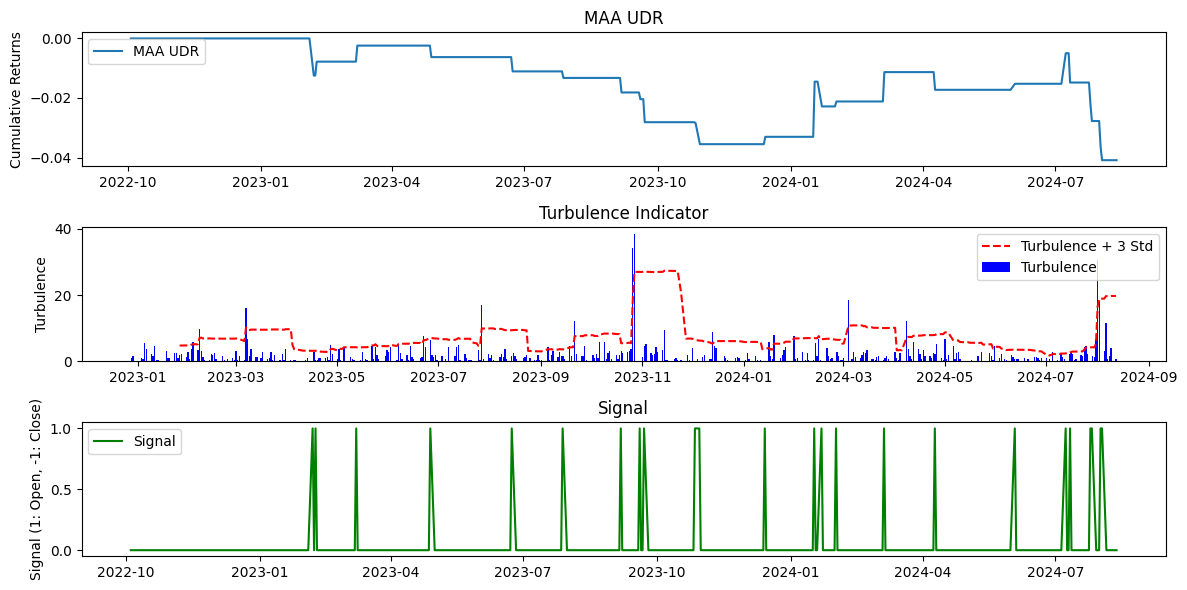

100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


In [199]:
cursor.execute(sql.SQL("select code, da, op from price where da > '2022-10-01' and da <= '2024-12-31' order by da asc;"))
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['code', 'da', 'cl']
pivoted = df.pivot(index='da', values='cl', columns='code')
pivoted = pd.read_parquet("stock_data_us_sp500.parquet").loc['2022-10-01':'2024-12-31']

pivoted_drop_latest = pivoted.iloc[:-7, :]
pivoted_dropna = pivoted_drop_latest.dropna(how='any', axis=1)
pct = pivoted_dropna.pct_change().fillna(0)
pct_cumprod = (1 + pct).cumprod() - 1

def plot_turbulences(pct):
    
    init = 60
    dates = pct.index[init:] 
    turbulences = [0.0] * len(dates)
    for i in range(len(dates)):
        mean = np.array(pct.mean())
        cov = np.array(pct.iloc[i:init+i].cov())
        pct_current = np.array(pct.iloc[init+i])
        
        turbulence = (pct_current - mean) @ np.linalg.inv(cov) @ (pct_current - mean).T
        turbulences[i] = turbulence
    df_test = pd.DataFrame(turbulences, index=dates, columns=["turbulence"])
    df_test.dropna(inplace=True)
    return df_test

ret = {}
for benchmark_100 in range(99, 98, -1):
    benchmark = float(benchmark_100/100) - 0.0001
    condition = (corrcoef < benchmark) & (corrcoef > benchmark - 0.01)
    row_col_pairs = list(zip(*np.where(condition)))
    row_col_pairs = [row for row in row_col_pairs if row[1] > row[0]]
    
    index = corrcoef.index
    columns = corrcoef.columns
    pairs = [None] * len(row_col_pairs)

    for i, pair in enumerate(row_col_pairs):
        
        first, second = index[pair[0]], index[pair[1]]
        pairs[i] = [first, second]


        
    pairs_ret = []
    for first, second in tqdm(pairs):
        try:
            calc = pct[[first, second]]
            turbulence = plot_turbulences(calc)
            calc['turbulence'] = turbulence


            fee = 0.95
            def signal_open(row):
                if row['turbulence'] > row['turbulence_2std']:
                    return 1
                elif row['turbulence'] < row['turbulence_mean']:
                    return -1
                else:
                    return 0

            calc['turbulence_mean'] = calc['turbulence'].rolling(20).mean()
            calc['turbulence_std'] = calc['turbulence'].rolling(20).std()
            calc['turbulence_2std'] = calc['turbulence_mean'] + 2 * calc['turbulence_std']
            # calc['turbulence_2std'] = calc['turbulence_2std'].shift(1)
            # calc['turbulence_mean'] = calc['turbulence_mean'].shift(1)
            calc['signal_open'] = calc.apply(signal_open, axis=1)
            calc['signal_open'] = calc['signal_open'].shift(1)
            calc[first + "_expected_return"] = calc[first].shift(-2)
            calc[second + "_expected_return"] = calc[second].shift(-2)
            calc['diff'] = calc[first] - calc[second]

            position = False
            pct_return = []
            for index, row in calc.iterrows():
                if not position and row['signal_open'] == 1:
                    if row['diff'] < 0:
                        type_ = 1
                        pct_return.append(-row[first+"_expected_return"]+row[second+"_expected_return"]*fee)
                    else:
                        type_ = 2
                        pct_return.append(row[first+"_expected_return"]-row[second+"_expected_return"]*fee)

                elif position and (row['signal_open'] == 1 or row['signal_open'] == 0):
                    if type_ == 1:
                        pct_return.append(-row[first+"_expected_return"]+row[second+"_expected_return"]*fee)
                    else:
                        pct_return.append(row[first+"_expected_return"]-row[second+"_expected_return"]*fee)
                elif position and row['signal_open'] == -1:
                    position = False
                else:
                    pct_return.append(0.0)
            calc['returns'] = pct_return
            calc['strat_cumprod'] = calc['returns'].cumsum()
            pairs_ret.append(calc['strat_cumprod'].iloc[-1])
            
            #####################################################################################
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

            # calc_1 = calc.loc['2021-05-01':"2021-06-30"]
            calc_1 = calc

            ax1.plot(calc_1.index, calc_1['strat_cumprod'], label=f'{first} {second}')
            ax1.set_title(f'{first} {second}')
            ax1.set_ylabel('Cumulative Returns')
            ax1.legend()

            ax2.bar(calc_1.index, calc_1['turbulence'], label='Turbulence', color='blue')
            ax2.plot(calc_1.index, calc_1['turbulence_2std'], label='Turbulence + 3 Std', color='red', linestyle='--')
            ax2.set_title('Turbulence Indicator')
            ax2.set_ylabel('Turbulence')
            ax2.legend()

            calc_1['signal_open'] = calc_1['signal_open'].apply(lambda x: 0 if x == -1 else x)
            ax3.plot(calc_1.index, calc_1['signal_open'], label='Signal', color='green')
            ax3.set_title('Signal')
            ax3.set_ylabel('Signal (1: Open, -1: Close)')
            ax3.legend()

            plt.tight_layout()
            plt.show()
            #####################################################################################
        except KeyError as e:
            pairs_ret.append(np.float64(0.0))
    outcome = pd.DataFrame(pairs)
    outcome['ret'] = pairs_ret
    
    mean_quantile = outcome['ret'].mean()
    ret[str(benchmark_100)] = mean_quantile



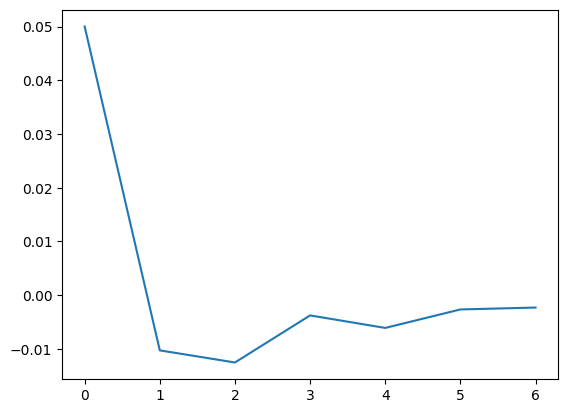

In [189]:
# op
# df1 = pd.DataFrame(ret)
# plt.bar()
plt.plot(ret.values())

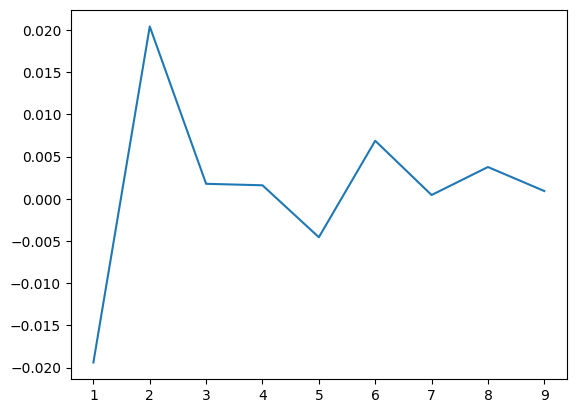

In [182]:
# df1 = pd.DataFrame(ret)
# plt.bar()
plt.plot(ret.values())
# cl

In [36]:
cursor.execute(sql.SQL("select code, da, cl from price where da > '2021-10-01' and da <= '2022-12-31' order by da asc;"))
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['code', 'da', 'cl']
pivoted = df.pivot(index='da', values='cl', columns='code')

pivoted_drop_latest = pivoted.iloc[:-7, :]
pivoted_dropna = pivoted_drop_latest.dropna(how='any', axis=1)
pct = pivoted_dropna.pct_change().fillna(0)
pct_cumprod = (1 + pct).cumprod() - 1


# for first i
first = '0051'
second = '00646'
calc = pct[[first, second]]
def plot_turbulences(pct):
    
    init = 60
    dates = pct.index[init:] 
    turbulences = [0.0] * len(dates)
    for i in range(len(dates)):
        mean = np.array(pct.mean())
        cov = np.array(pct.iloc[i:init+i].cov())
        pct_current = np.array(pct.iloc[init+i])
        
        turbulence = (pct_current - mean) @ np.linalg.inv(cov) @ (pct_current - mean).T
        turbulences[i] = turbulence
    df_test = pd.DataFrame(turbulences, index=dates, columns=["turbulence"])
    df_test.dropna(inplace=True)
    return df_test

turbulence = plot_turbulences(calc)
calc['turbulence'] = turbulence


In [55]:
import warnings
warnings.filterwarnings('ignore')
fee = 0.9
def signal_open(row):
    if row['turbulence'] > row['turbulence_2std']:
        return 1
    elif row['turbulence'] < row['turbulence_mean']:
        return -1
    else:
        return 0

calc['turbulence_mean'] = calc['turbulence'].rolling(20).mean()
calc['turbulence_std'] = calc['turbulence'].rolling(20).std()
calc['turbulence_2std'] = calc['turbulence_mean'] + 3 * calc['turbulence_std']
# calc['turbulence_2std'] = calc['turbulence_2std'].shift(1)
# calc['turbulence_mean'] = calc['turbulence_mean'].shift(1)
calc['signal_open'] = calc.apply(signal_open, axis=1)
calc['signal_open'] = calc['signal_open'].shift(1)
calc[first + "_expected_return"] = calc[first].shift(-3)
calc[second + "_expected_return"] = calc[second].shift(-3)
calc['diff'] = calc[first] - calc[second]

position = False
pct_return = []
for index, row in calc.iterrows():
    if not position and row['signal_open'] == 1:
        if row['diff'] < 0:
            type_ = 1
            pct_return.append(-row[first+"_expected_return"]+row[second+"_expected_return"]*fee)
        else:
            type_ = 2
            pct_return.append(row[first+"_expected_return"]-row[second+"_expected_return"]*fee)

    elif position and (row['signal_open'] == 1 or row['signal_open'] == 0):
        if type_ == 1:
            pct_return.append(-row[first+"_expected_return"]+row[second+"_expected_return"]*fee)
        else:
            pct_return.append(row[first+"_expected_return"]-row[second+"_expected_return"]*fee)
    elif position and row['signal_open'] == -1:
        position = False
    else:
        pct_return.append(0.0)
calc['returns'] = pct_return
calc['strat_cumprod'] = calc['returns'].cumsum()

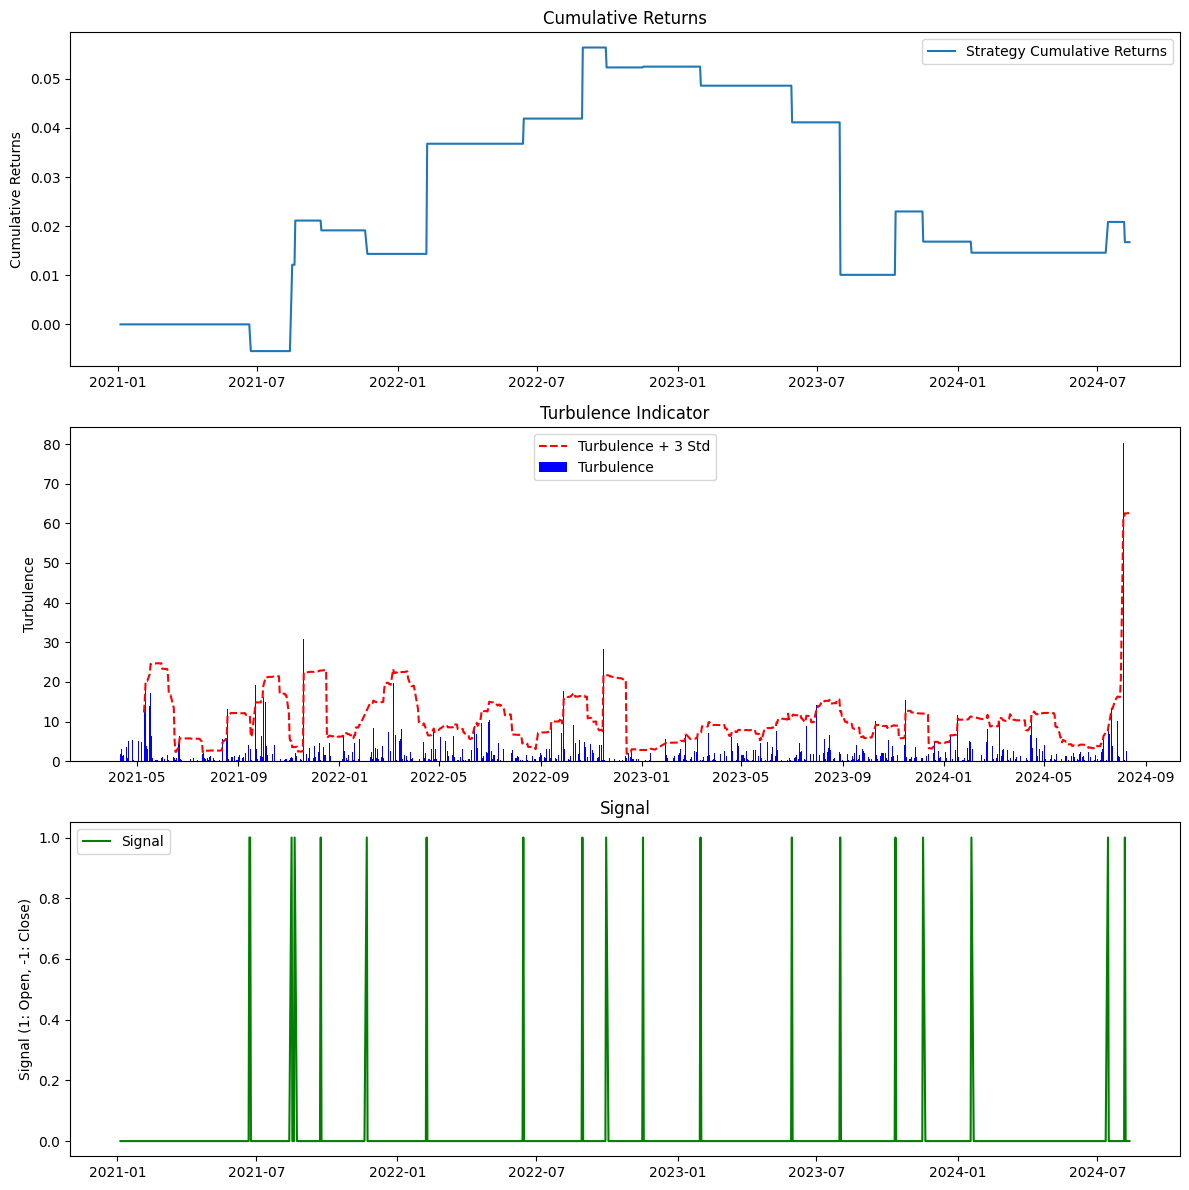

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# calc_1 = calc.loc['2021-05-01':"2021-06-30"]
calc_1 = calc

ax1.plot(calc_1.index, calc_1['strat_cumprod'], label='Strategy Cumulative Returns')
ax1.set_title('Cumulative Returns')
ax1.set_ylabel('Cumulative Returns')
ax1.legend()

ax2.bar(calc_1.index, calc_1['turbulence'], label='Turbulence', color='blue')
ax2.plot(calc_1.index, calc_1['turbulence_2std'], label='Turbulence + 3 Std', color='red', linestyle='--')
ax2.set_title('Turbulence Indicator')
ax2.set_ylabel('Turbulence')
ax2.legend()

calc_1['signal_open'] = calc_1['signal_open'].apply(lambda x: 0 if x == -1 else x)
ax3.plot(calc_1.index, calc_1['signal_open'], label='Signal', color='green')
ax3.set_title('Signal')
ax3.set_ylabel('Signal (1: Open, -1: Close)')
ax3.legend()

plt.tight_layout()
plt.show()